In [16]:
#import libraries
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from IPython.display import display, clear_output
import time

In [17]:
#define date range
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2025,10, 11)

In [18]:
#define starting variables
symbols = ["^nsei"]
systems = ["Strat", "Strat_5ma_stop", "BuyHold"]#"Strat_200ma_stop", "Strat_5ma_stop", "Strat_0d_hold", "Strat_trail", "BuyHold"]
starting_balance = 10000
slow_ma = 200
fast_ma = 5
periods = [7]
#periods.extend(range(2, 11, 1))

In [19]:
def get_price_data(symbol):
    #download data
    price = yf.download(symbol, start, end) 
    
    #drop redundant columns
    price = price.drop(["Volume", "Adj Close"], axis=1)
    
    return price

In [20]:
def calculate_inputs(df, s, per):
    #calculate inputs required for system
    
    #calculate moving averages
    df["Fast_MA"] = df.Close.rolling(window = fast_ma).mean()
    df["Slow_MA"] = df.Close.rolling(window = slow_ma).mean()

    #check if today's close is a 7 day low
    df['Low_7'] = df.Close == df.Close.rolling(window = per).min()
    #check if today's close is a 7 day high
    df['High_7'] = df.Close == df.Close.rolling(window = per).max()
    
    #get the rolling 7 day low then check if today is that 7 day low
    #df['Low_7'] = df.Low == df.Low.rolling(window = per).min()
    #get the rolling 7 day high then check if today is that 7 day high
    #df['High_7'] = df.High == df.High.rolling(window = per).max()
    
    return df

In [21]:
def generate_signals(df, s):
    #generate entries and exits
    if s == "BuyHold":
        df[f"{s}_Signal"] = True
    else:
        #entry is taken if the conditions were met at yesterday's close
        df[f"{s}_Signal"] = (df.Low_7.shift(1) == True) & (df.Close.shift(1) > df.Slow_MA.shift(1))

        #exits depend on the strategy
        if s == "Strat":
            #exit is on today's close
            df[f"{s}_Exit"] = (df.High_7 == True)
        elif s == "Strat_200ma_stop":
            #exit is on today's close with a stop loss below the 200 day MA
            df[f"{s}_Exit"] = (df.High_7 == True) | (df.Close < df.Slow_MA)
        elif s == "Strat_5ma_stop":
            #exit if price closes above the fast MA
            df[f"{s}_Exit"] = (df.Close > df.Fast_MA)
        elif s == "Strat_0d_hold":
            #exit the same day
            df[f"{s}_Exit"] = True | (df.Close < df.Slow_MA)
        elif s == "Strat_trail":
            #trailing stop so no pre defined exit
            df[f"{s}_Exit"] = False
    return df

In [22]:
def generate_trades(df, s):
    if s == "BuyHold":
        #calculate benchmark return and balance
        df[f"{s}_Trade"] = True
        df[f"{s}_In_Market"] = True
        df[f"{s}_Ret"] = df.Close / df.Close.shift(1)
        df[f"{s}_Ret"].iat[0] = 1
        df[f"{s}_Bal"] = starting_balance * df[f"{s}_Ret"].cumprod()
        df[f"{s}_Running_Bal"] = df[f"{s}_Bal"]
        df[f"{s}_Entry_Price"] = df.Close
    else:
        #create empty list for trades
        trades_list = []
        trade_open = False
        open_change = {}
        stop_loss = 0
        
        #iterate through rows to work out entries and exits
        for i, row in df.iterrows():
            #if there is currently no trade
            if trade_open == False:
                #check if long signal was generated at the close and enter at the same time
                if row[f"{s}_Signal"] == True:
                    entry_date = i
                    entry_price = row.Open
                    trade_open = True
            #check if a trade is already open
            if trade_open == True:
                #check if an exit signal has been generated on today's close and sell shares
                if row[f"{s}_Exit"] == True:
                    exit_date = i
                    exit_price = row.Close
                    trade_open = False
                    #store trade data in a list
                    trade = [entry_date, entry_price, exit_date, exit_price, True]
                    #append trade to overall trade list
                    trades_list.append(trade)
                else:
                    #otherwise track the open change while the trade is open to monitor balance during the trade.
                    open_change[i] = row.Low / entry_price
                    #check if trailing stop is hit
                    if s == "Strat_trail":
                        #exit if first day is red, otherwise place trailing stop loss to bottom of day
                        if np.busday_count(entry_date.date(), i.date()) == 0:
                            if row.Close <= entry_price:
                                exit_date = i
                                exit_price = row.Close
                                trade_open = False
                                #store trade data in a list
                                trade = [entry_date, entry_price, exit_date, exit_price, True]
                                #print(trade)
                                #append trade to overall trade list
                                trades_list.append(trade)
                            else:
                                #move trailing stop
                                stop_loss = row.Low
                        #if the trade is past the first day and is being held, then check the stop loss
                        else:
                            #monitor trailing stop
                            if stop_loss:
                                #first check for a gap down
                                if row.Open <= stop_loss:
                                    exit_date = i
                                    exit_price = row.Open
                                    trade_open = False
                                    stop_loss = 0
                                    #store trade data in a list
                                    trade = [entry_date, entry_price, exit_date, exit_price, True]
                                    #append trade to overall trade list
                                    trades_list.append(trade)
                                elif row.Low <= stop_loss:
                                    exit_date = i
                                    exit_price = stop_loss
                                    trade_open = False
                                    stop_loss = 0
                                    #store trade data in a list
                                    trade = [entry_date, entry_price, exit_date, exit_price, True]
                                    #append trade to overall trade list
                                    trades_list.append(trade)
                                else:
                                    #move trailing stop
                                    stop_loss = row.Low
                    
        trades = pd.DataFrame(trades_list, columns = ["Entry_Date", "Entry_Price", "Exit_Date", "Exit_Price", "Sys_Trade"])
        
        #calculate return of each trade as well as the trade duration
        trades[f"{s}_Return"] = trades.Exit_Price / trades.Entry_Price
        dur = []
        for i, row in trades.iterrows():
            d1 = row.Entry_Date
            d2 = row.Exit_Date
            dur.append(np.busday_count(d1.date(), d2.date()) + 1)#Add 1 because formula doesn't include the end date otherwise
        
        trades[f"{s}_Duration"] = dur
    
        #create a new dataframe with an index of exit dfs
        returns = pd.DataFrame(index = trades.Exit_Date)
        #create a new dataframe with an index of entries to track entry price
        entries = pd.DataFrame(index = trades.Entry_Date)

        entries[f"{s}_Entry_Price"] = pd.Series(trades.Entry_Price).values
        #add the Return column to this new data frame
        returns[f"{s}_Ret"] = pd.Series(trades[f"{s}_Return"]).values
        returns[f"{s}_Trade"] = pd.Series(trades.Sys_Trade).values
        returns[f"{s}_Duration"] = pd.Series(trades[f"{s}_Duration"]).values
        change_ser = pd.Series(open_change, name=f"{s}_Change")
    
        #add the returns from the trades to the main data frame
        df = pd.concat([df, returns, entries, change_ser], axis = 1)
        #fill all the NaN return values with 1 as there was no profit or loss on those days
        df[f"{s}_Ret"] = df[f"{s}_Ret"].fillna(1)
        #fill all the NaN trade values with False as there was no trade on those days
        df[f"{s}_Trade"] = df[f"{s}_Trade"].infer_objects(copy=False)
        #fill all the NaN return values with 1 as there was no loss on those days
        df[f"{s}_Change"] = df[f"{s}_Change"].astype(float).fillna(1)
        
        #calculate system balance
        df[f"{s}_Bal"] = starting_balance * df[f"{s}_Ret"].cumprod()
        #calculate the running balance
        df[f"{s}_Running_Bal"] = df[f"{s}_Bal"] * df[f"{s}_Change"]
    
        active_trades = np.where(df[f"{s}_Trade"] == True, True, False)
        df[f"{s}_In_Market"] = df[f"{s}_Trade"].copy()
        #populate trades column based on duration
        for count, t in enumerate(active_trades):
            if t == True:
                dur = df[f"{s}_Duration"].iat[count]
                for i in range(int(dur)):
                    #starting from the exit date, move backwards and mark each trading day
                    df[f"{s}_In_Market"].iat[count - i] = True
    
    return df

In [23]:
def backtest(price, per):

    for s in systems:
        #calculate strategy inputs
        price = calculate_inputs(price, s, per)
        #generate signals
        price = generate_signals(price, s)
        #generate trades
        price = generate_trades(price, s)

    for s in systems:
        #calculate drawdown
        price[f"{s}_Peak"] = price[f"{s}_Bal"].cummax()
        price[f"{s}_DD"] = price[f"{s}_Bal"] - price[f"{s}_Peak"]
        price[f"{s}_Running_DD"] = price[f"{s}_Running_Bal"] - price[f"{s}_Peak"]

    return price

In [24]:
results = []
prog = 0
max_prog = len(symbols) * len(periods)
start_time = time.time()
for sym in symbols:
    price = get_price_data(sym)
    for per in periods:
        result = backtest(price, per)
        results.append(result)
        prog += 1
        clear_output(wait=True)
        print(f"Progress: {round((prog / max_prog) * 100)} %")
end_time = time.time()
print(f"Total Time Elapsed: {end_time - start_time} s")

Progress: 100 %
Total Time Elapsed: 0.5026347637176514 s


In [25]:
#calculate metrics
def get_metrics(system, data):
    rfr = 0.0#3 # risk free return rate of 3%
    N = 252 # number of trading days per year
    metrics = {}
    years = (data.index[-1] - data.index[0]).days / 365.25
    sys_return = round(((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0]) - 1) * 100, 2)
    sys_cagr = round(((((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0])**(1/years))-1)*100), 2)
    sys_peak = data[f"{system}_Bal"].cummax()
    sys_dd = round(((data[f"{system}_DD"] / data[f"{system}_Peak"]).min()) * 100, 2)
    sys_running_dd = round(((data[f"{system}_Running_DD"] / data[f"{system}_Peak"]).min()) * 100, 2)
    rod = sys_cagr / abs(sys_running_dd)
    periods_in_market = data[f"{system}_In_Market"].sum()
    
    win = data[f"{system}_Ret"] > 1
    loss = data[f"{system}_Ret"] < 1
    signals = data[f"{system}_Signal"].sum()
    trades_triggered = data[f"{system}_Trade"].sum()
    tim = round(periods_in_market / len(data) * 100, 2)
    rbe = round((sys_cagr / tim) * 100, 2)
    rbeod = rbe / abs(sys_running_dd) # return by exposure by drawdown (assuming drawdown doesn"t scale as TIM increases. Could be wrong)
    gaps = (data.Open > data[f"{system}_Entry_Price"]).sum()
    non_gaps = (data.Open <= data[f"{system}_Entry_Price"]).sum()
    wins = win.sum()
    losses = loss.sum()
    winrate = round(wins / (wins + losses) * 100, 2)
    
    # calculate the size of the move from the entry data to the close
    ret_size = np.where(data[f"{system}_Trade"] == True, data[f"{system}_Ret"], 1)
    avg_up_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] > 1].mean() - 1) * 100
    max_up_move = (data[f"{system}_Ret"].max() - 1) * 100
    avg_down_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] < 1].mean() - 1) * 100
    max_down_move = (data[f"{system}_Ret"].min() - 1) * 100
    avg_rr = round(abs(avg_up_move / avg_down_move), 2)

    #sharpe ratio
    daily_ret = data[f"{system}_Bal"].pct_change()
    excess_ret = daily_ret - rfr/N
    sharpe = np.sqrt(N) * excess_ret.mean() / excess_ret.std()

    #sortino ratio
    downside_std = daily_ret[daily_ret < 0].std()
    sortino = np.sqrt(N) * excess_ret.mean() / downside_std
        
    #save data
    metrics["Start_Balance"] = round(data[f"{system}_Bal"].iat[0], 2)
    metrics["Final_Balance"] = round(data[f"{system}_Bal"].iat[-1], 2)
    metrics["Total_Return"] = round(sys_return, 2)
    metrics["Annual_Return"] = round(sys_cagr, 2)
    metrics["Time_in_Market"] = round(tim, 2)
    metrics["Return_By_Exposure"] = rbe
    metrics["Max_Drawdown"] = round(sys_dd, 2)
    metrics["Max_Running_Drawdown"] = round(sys_running_dd, 2)
    metrics["Return_Over_Drawdown"] = round(rod, 2)
    metrics["RBE_Over_Drawdown"] = round(rbeod, 2)
    metrics["Sharpe"] = round(sharpe, 2)
    metrics["Sortino"] = round(sortino, 2)
    metrics["Signals"] = round(signals, 2)
    metrics["Trades"] = round(trades_triggered, 2)
    
    metrics["Gap"] = round(gaps)
    metrics["No_Gap"] = round(non_gaps)
    metrics["Wins"] = round(wins, 2)
    metrics["Losses"] = round(losses, 2)
    metrics["Winrate"] = round(winrate, 2)
    metrics["Max_Trade_Return_pct"] = round(max_up_move, 2)
    metrics["Max_Trade_Loss_pct"] = round(max_down_move, 2)
    metrics["Avg_Trade_Return_pct"] = round(avg_up_move, 2)
    metrics["Avg_Trade_Loss_pct"] = round(avg_down_move, 2)
    metrics["Avg_RR"] = avg_rr
    
    return metrics

In [26]:
full_metrics = {}
for count, res in enumerate(results):
    sys_metrics = {}
    for s in systems:
        sys_metrics.update({s: get_metrics(s, res)})
    sys_metrics_df = pd.DataFrame.from_dict(sys_metrics)
    full_metrics.update({periods[count]: sys_metrics_df})

In [27]:
# compared_metrics = pd.DataFrame(columns=["sys", "cagr", "tim", "rbe", "max_dd", "running_dd", "rod", "rbeod", "winrate", "rr", "rbeod200", "rbeod5", "rbeod0d", "rbeod_trail"])

# for per in periods:
#     data = full_metrics[per]
#     sys = f"Period_{per}"
#     cagr = data[systems[0]].loc["Annual_Return"]
#     tim = data[systems[0]].loc["Time_in_Market"]
#     rbe = data[systems[0]].loc["Return_By_Exposure"]
#     max_dd = data[systems[0]].loc["Max_Drawdown"]
#     running_dd = data[systems[0]].loc["Max_Running_Drawdown"]
#     rod = data[systems[0]].loc["Return_Over_Drawdown"]
#     rbeod = data[systems[0]].loc["RBE_Over_Drawdown"]
#     winrate = data[systems[0]].loc["Winrate"]
#     rr = data[systems[0]].loc["Avg_RR"]
#     rbeod200 = data[systems[1]].loc["RBE_Over_Drawdown"]
#     rbeod5 = data[systems[2]].loc["RBE_Over_Drawdown"]
#     rbeod0d = data[systems[3]].loc["RBE_Over_Drawdown"]
#     rbeod_trail = data[systems[4]].loc["RBE_Over_Drawdown"]
    
#     new_row = [sys, cagr, tim, rbe, max_dd, running_dd, rod, rbeod, winrate, rr, rbeod200, rbeod5, rbeod0d, rbeod_trail]
#     compared_metrics.loc[len(compared_metrics)] = new_row
#     count += 1

In [28]:
#compared_metrics

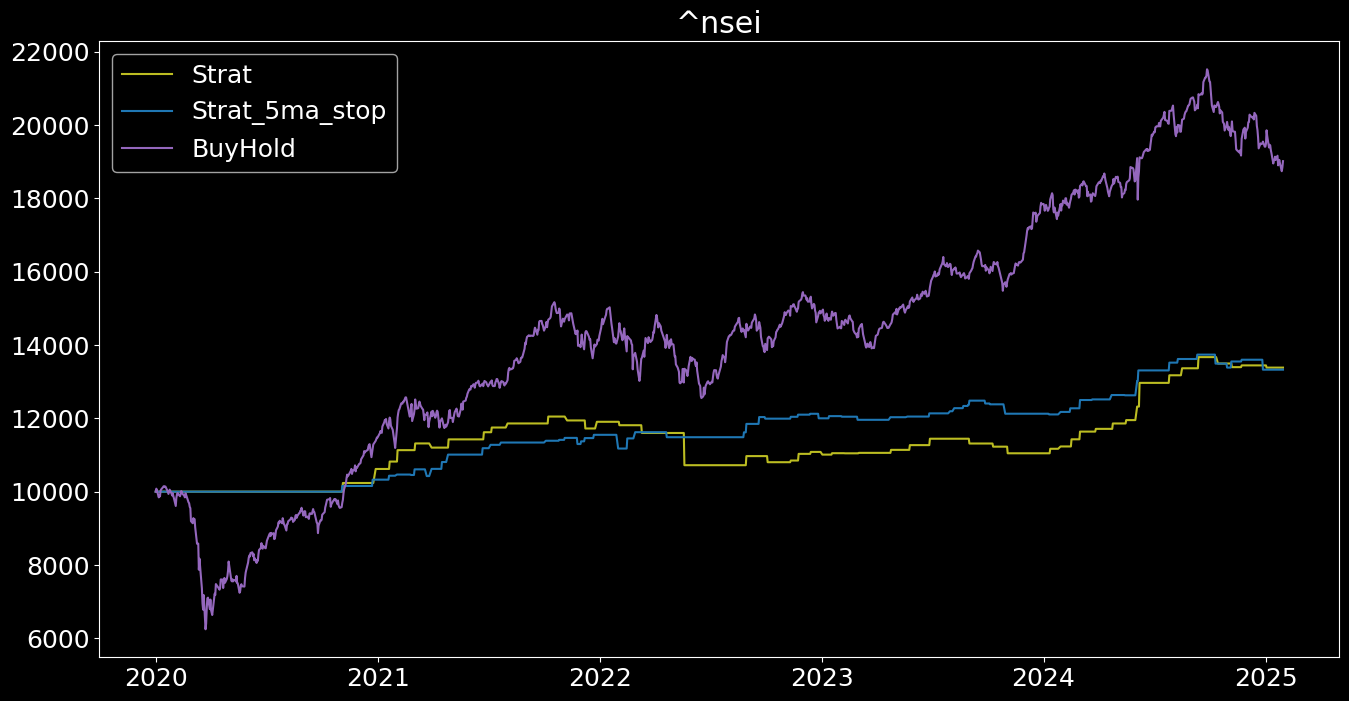

In [29]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams.update({"font.size": 18})

colours = ["tab:olive", "tab:blue", "tab:purple", "tab:orange", "tab:green", "tab:cyan"]

for count, sym in enumerate(symbols):
    plt.figure()
    plt.title(sym)
    for c, s in enumerate(systems):
        plt.plot(results[0][f"{s}_Bal"], colours[c])

plt.legend(systems)
plt.show()

In [30]:
for m in full_metrics:
    print(m)
    print(full_metrics[m])

7
                         Strat  Strat_5ma_stop   BuyHold
Start_Balance         10000.00        10000.00  10000.00
Final_Balance         13383.21        13327.12  19013.42
Total_Return             33.83           33.27     90.13
Annual_Return             5.91            5.82     13.49
Time_in_Market           31.00           18.04    100.00
Return_By_Exposure       19.06           32.26     13.49
Max_Drawdown            -11.01           -3.24    -38.44
Max_Running_Drawdown    -13.91           -6.05    -38.44
Return_Over_Drawdown      0.42            0.96      0.35
RBE_Over_Drawdown         1.37            5.33      0.35
Sharpe                    0.97            1.31      0.77
Sortino                   0.22            0.41      0.87
Signals                 131.00          131.00   1258.00
Trades                   48.00           64.00   1258.00
Gap                       0.00            0.00    645.00
No_Gap                   48.00           64.00    613.00
Wins                     33.0